# Reproducing tabular experiments

In this notebook, we visualize the results of the tabular experiments described in the paper.

To obtain the results, you should run run_experiments/run_all_tabular_experiments.py.

# Imports

In [34]:
import sys

import matplotlib
import numpy as np

sys.path.insert(0, "../")
sys.path.insert(0, "../src")
sys.path.insert(0, "../src/run_experiments")

from display_results_helper import get_comparison_df, plot_metrics, depth_data_plot, horizontal_plot_metrics
from src.calibration.parameters_free_online_calibration import ParameterFreeOnlineCalibration
from src.calibration.stretching_functions.stretching_functions_factory import IdentityStretchingFactory, \
    ExponentialStretchingFactory, ErrorAdaptiveStretchingFactory
from src.calibration.calibrations_factory import ACIFactory
from src.calibration.calibrations_factory import RollingRiskControlFactory
from src.calibration.set_constructing_functions.set_constructing_function_factory import \
    PredictionIntervalConstructingFunctionWithCQRFactory
from run_experiments.multi_calibration_tabular import RegressionObjectiveLoss
from src.losses import MiscoverageLoss, MiscoverageCounterLoss
from src.calibration.dummy_calibration import DummyCalibration
from src.losses_factory import MiscoverageLossFactory, MiscoverageCounterLossFactory

matplotlib.rc('font', **{'size': 20})

import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
desired_coverage_level = 90
alpha = np.round(1- desired_coverage_level /100, 3)
dataset_names = ['energy', 'traffic', 'prices', 'tetuan_power', 'wind']
seeds = 20
display_errors = True


# Controlling the miscoverage loss - RRC stretchings

metric:  coverage


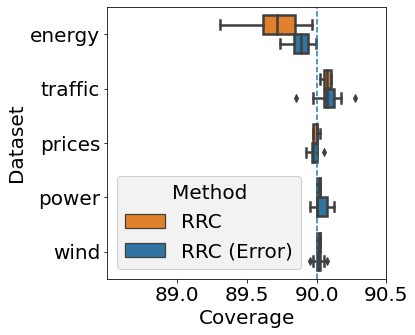

metric:  average miscoverage streak length


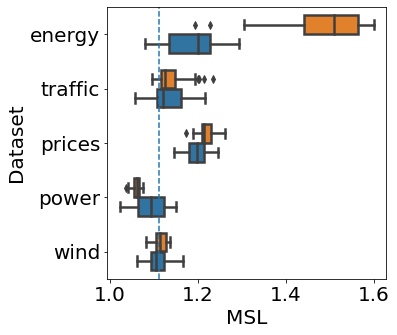

metric:  average length


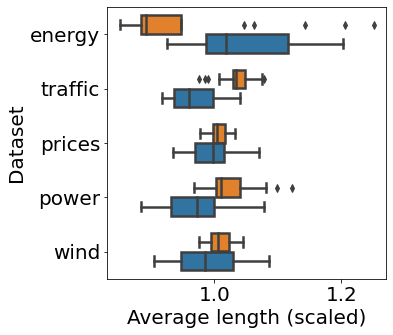

metric:  average miscoverage counter
mc_alpha:  0.1111111111111111


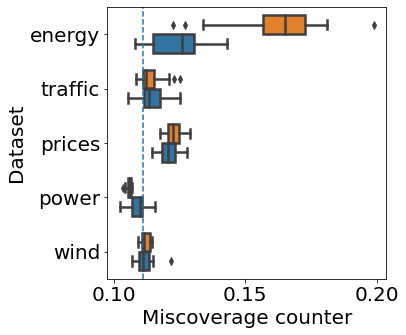

In [67]:
calibration_set_size = 300
objective_loss = RegressionObjectiveLoss(alpha)

calibration_schemes = []
# calibration_schemes.append(DummyCalibration())
for loss_factory in [MiscoverageLossFactory()]:
    for stretching_factory in [
                               IdentityStretchingFactory(), 
#                                ExponentialStretchingFactory(), 
                               ErrorAdaptiveStretchingFactory(loss_factory, alpha)
                              ]:
        set_constructing_function_factory = PredictionIntervalConstructingFunctionWithCQRFactory(stretching_factory)
        rrc_factory = RollingRiskControlFactory(alpha, set_constructing_function_factory, loss_factory)
        calibration = ParameterFreeOnlineCalibration(objective_loss, rrc_factory)
        calibration_schemes.append(calibration)

total_df = get_comparison_df(seeds, dataset_names, calibration_schemes, display_errors=False)
metrics = ['coverage', 'average miscoverage streak length', 'average length', 'average miscoverage counter']
plot_metrics(total_df, metrics, desired_coverage_level, save_dir='controlling miscoverage loss - RRC stretchings')

# Baselines comparison: RRC vs Naive & ACI

metric:  coverage


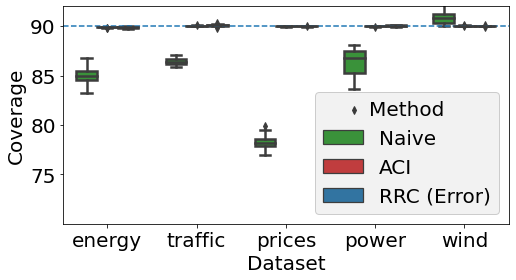

metric:  average miscoverage streak length


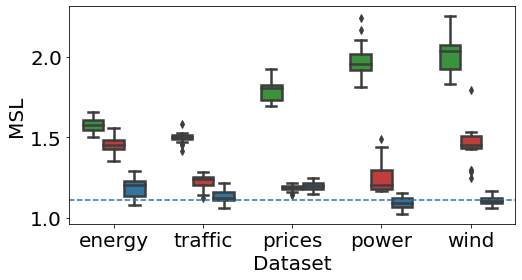

metric:  average length


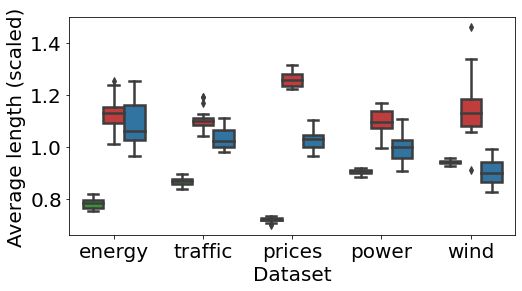

metric:  average miscoverage counter
mc_alpha:  0.1111111111111111


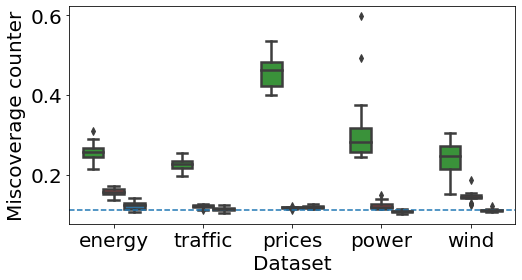

In [68]:
calibration_set_size = 300
objective_loss = RegressionObjectiveLoss(alpha)

calibration_schemes = []
calibration_schemes.append(DummyCalibration())
aci_factory = ACIFactory(alpha, calibration_set_size)
param_free_aci = ParameterFreeOnlineCalibration(objective_loss, aci_factory)
calibration_schemes.append(param_free_aci)
for loss in [MiscoverageLossFactory()]:
    for stretching_factory in [
#                                IdentityStretchingFactory(), 
#                                ExponentialStretchingFactory(), 
                               ErrorAdaptiveStretchingFactory(loss, alpha)
                              ]:
        set_constructing_function_factory = PredictionIntervalConstructingFunctionWithCQRFactory(stretching_factory)
        rrc_factory = RollingRiskControlFactory(alpha, set_constructing_function_factory, loss)
        calibration = ParameterFreeOnlineCalibration(objective_loss, rrc_factory)
        calibration_schemes.append(calibration)

total_df = get_comparison_df(seeds, dataset_names, calibration_schemes, display_errors=False)
metrics = ['coverage', 'average miscoverage streak length', 'average length', 'average miscoverage counter']
horizontal_plot_metrics(total_df, metrics, desired_coverage_level, 
                        save_dir='controlling miscoverage loss - RRC vs Naive, ACI')

# Controlling the miscoverage counter loss

metric:  average miscoverage counter
mc_alpha:  0.1111111111111111


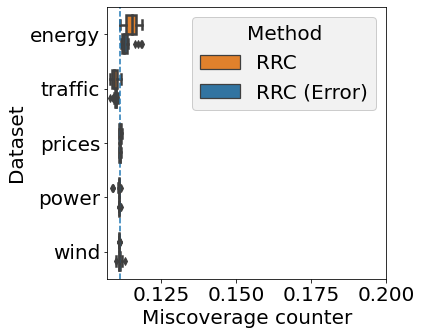

metric:  coverage


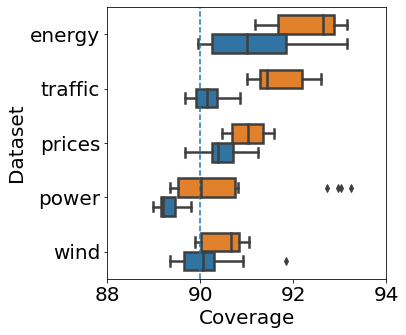

In [69]:
calibration_set_size = 300
mc_alpha = alpha / (1-alpha)

objective_loss = RegressionObjectiveLoss(alpha)

calibration_schemes = []
# calibration_schemes.append(DummyCalibration())
aci_factory = ACIFactory(alpha, calibration_set_size)
param_free_aci = ParameterFreeOnlineCalibration(objective_loss, aci_factory)
# calibration_schemes.append(param_free_aci)
for loss in [MiscoverageCounterLossFactory()]:
    for stretching_factory in [
                               IdentityStretchingFactory(), 
#                                ExponentialStretchingFactory(), 
                               ErrorAdaptiveStretchingFactory(loss, mc_alpha)
                              ]:
        set_constructing_function_factory = PredictionIntervalConstructingFunctionWithCQRFactory(stretching_factory)
        rrc_factory = RollingRiskControlFactory(alpha, set_constructing_function_factory, loss)
        calibration = ParameterFreeOnlineCalibration(objective_loss, rrc_factory)
        calibration_schemes.append(calibration)

total_df = get_comparison_df(seeds, dataset_names, calibration_schemes, display_errors=True)
metrics = ['average miscoverage counter', 'coverage']
plot_metrics(total_df, metrics, desired_coverage_level, save_dir='controlling miscoverage counter loss')

# Reproducing depth experiments

In [42]:
depth_seeds = 10
depth_desired_coverage_level = 80

## Multiple risks control: image miscoverage and center failure rate

metric:  Image coverage


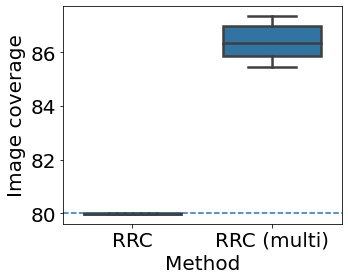

metric:  Average length


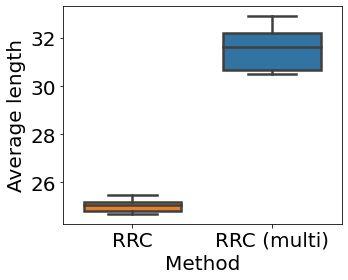

metric:  Center failure rate


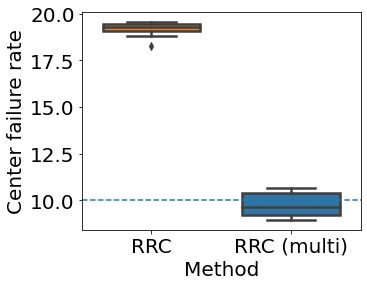

In [76]:
multiple_losses = ['image_miscoverage', 'poor_center_coverage']
single_loss = ['image_miscoverage']
metrics = [
    'image coverage',
    'image average length',
#     'center coverage',
#     'center average length',
    'center poor coverage occurrences (60.0 %)',
]

depth_data_plot(seeds=depth_seeds, desired_coverage_level=depth_desired_coverage_level,
                    full_dataset_name='KITTI',
                    calibration_methods=[
#                         'uncalibrated',
                        f"parameter_free_multi_rrc_f=cqr_exp_losses={single_loss}".replace(" ", "_"),
                        f"parameter_free_multi_rrc_f=cqr_exp_losses={multiple_losses}".replace(" ", "_"),
                                        ],
                    model_names=[
#                                 'depth_bb=res101_std=baseline',
#                                  'depth_bb=res101_std=residual_magnitude',
                                 'depth_bb=res101_std=previous_residual_with_alignment',
                                 ],
                save_dir = 'depth minimal figures',
                
                    display_errors=False,
                   metrics=metrics)

# Appendix experiments

## Comparing RRC to baselines

metric:  coverage


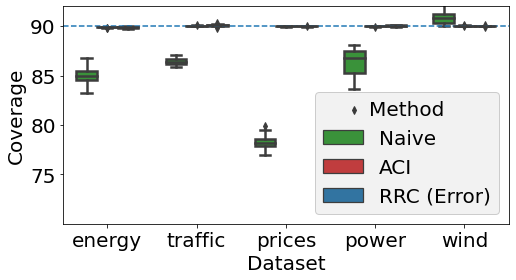

metric:  average miscoverage streak length


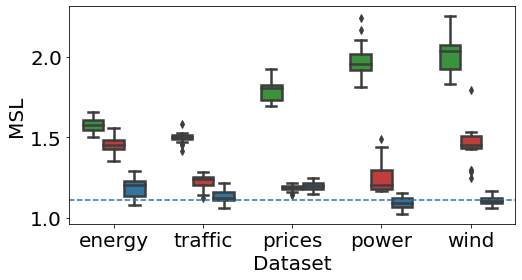

metric:  average length


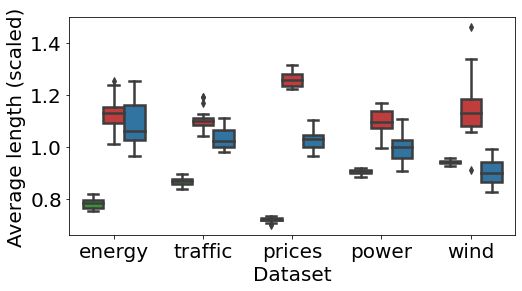

metric:  average miscoverage counter
mc_alpha:  0.1111111111111111


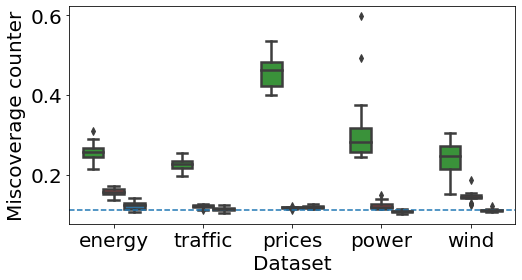

metric:  days avg. Δ-coverage


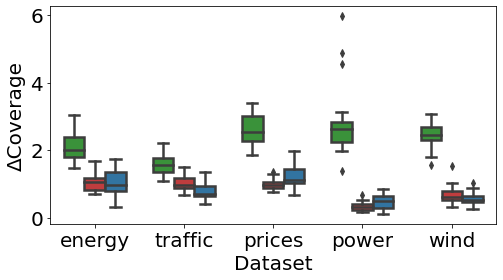

In [74]:
calibration_set_size = 300
objective_loss = RegressionObjectiveLoss(alpha)

calibration_schemes = []
calibration_schemes.append(DummyCalibration())
aci_factory = ACIFactory(alpha, calibration_set_size)
param_free_aci = ParameterFreeOnlineCalibration(objective_loss, aci_factory)
calibration_schemes.append(param_free_aci)
for loss in [MiscoverageLossFactory()]:
    for stretching_factory in [
#                                IdentityStretchingFactory(), 
#                                ExponentialStretchingFactory(), 
                               ErrorAdaptiveStretchingFactory(loss, alpha)
                              ]:
        set_constructing_function_factory = PredictionIntervalConstructingFunctionWithCQRFactory(stretching_factory)
        rrc_factory = RollingRiskControlFactory(alpha, set_constructing_function_factory, loss)
        calibration = ParameterFreeOnlineCalibration(objective_loss, rrc_factory)
        calibration_schemes.append(calibration)

total_df = get_comparison_df(seeds, dataset_names, calibration_schemes, display_errors=False)
metrics = ['coverage', 'average miscoverage streak length', 'average length', 
           'average miscoverage counter', 'days avg. Δ-coverage']
horizontal_plot_metrics(total_df, metrics, desired_coverage_level, 
                        save_dir='horizontal plot- controlling miscoverage loss - RRC vs Naive, ACI')

# Total comparison

metric:  Image coverage


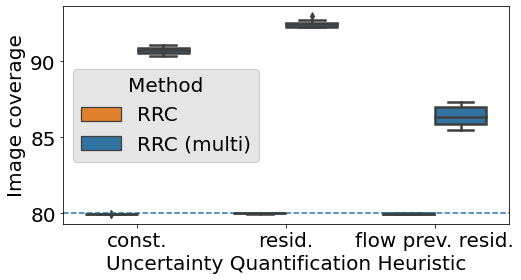

metric:  Average length


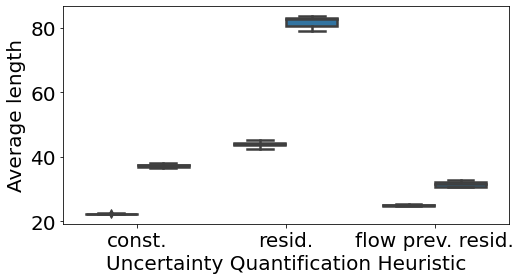

metric:  Center coverage


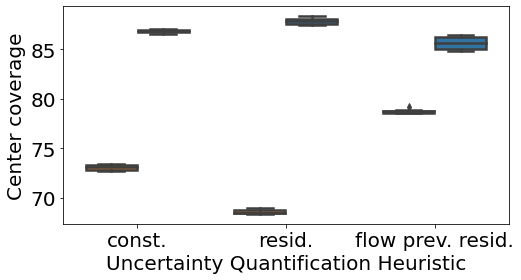

metric:  Center length


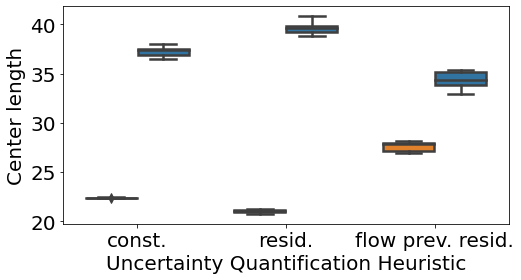

metric:  Center failure rate


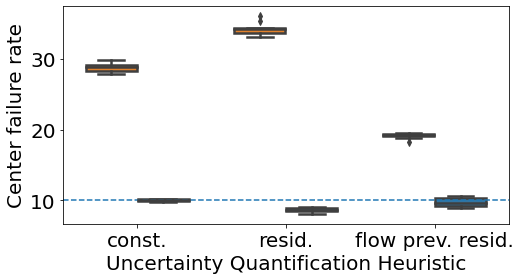

In [81]:
multiple_losses = ['image_miscoverage', 'poor_center_coverage']
single_loss = ['image_miscoverage']

metrics = [
    'image coverage',
    'image average length',
    'center coverage',
    'center average length',
    'center poor coverage occurrences (60.0 %)',
]

depth_data_plot(seeds=depth_seeds, desired_coverage_level=depth_desired_coverage_level,
                    full_dataset_name='KITTI',
                    calibration_methods=[
                        f"parameter_free_multi_rrc_f=cqr_exp_losses={single_loss}".replace(" ", "_"),
                        f"parameter_free_multi_rrc_f=cqr_exp_losses={multiple_losses}".replace(" ", "_"),
                                        ],
                    model_names=[
                                'depth_bb=res101_std=baseline',
                                 'depth_bb=res101_std=residual_magnitude',
                                 'depth_bb=res101_std=previous_residual_with_alignment',
                                 ],
                save_dir='all depth',
                    display_errors=False,
                   metrics=metrics)